# without CPU speeding up

In [ ]:
# Import required modules
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(variable_parameters, map_scheme, seed_value):
    """Run the SugarScape model with given parameters and log the process."""
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'],
                       map_scheme=map_scheme,
                       seed_value=seed_value)
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Output every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, map_scheme={map_scheme}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[2, 8], [2, 13]]
}

# Set experiment parameters
replicates = 10  # Simplify debugging
max_steps = 500 # Increase steps
distinct_samples = 4  # Set as 2^n

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)

# Create parameter list
param_list = []
for i in range(replicates):
    for vals in param_values:
        # Convert parameter sample values to integers
        variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
        param_list.append(variable_parameters)

# Initialize data storage
data_uniform = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
data_random = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
data_clustered = pd.DataFrame(index=range(total_runs), columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])

# Run model in single process
map_schemes = ['split','uniform', 'top_heavy']
seed_value = None  # or None for different results each time

for map_scheme in map_schemes:
    results = []
    for params in tqdm(param_list, desc=f"Running for map_scheme={map_scheme}"):
        results.append(run_model(params, map_scheme, seed_value))

    # Save results
    data = pd.DataFrame(results, columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])
    data.to_csv(f'simulation_results_{map_scheme}.csv', index=False)

print("All experiments done!")



# with CPU speeding up
but not functioning well i think cuz the printing is stuck
i dont know why its stuck

In [ ]:
# Import required modules
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
import os

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger(f"worker_{os.getpid()}")
    handler = logging.FileHandler(f"worker_{os.getpid()}.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(params):
    """Run the SugarScape model with given parameters and log the process."""
    variable_parameters, map_scheme, seed_value = params
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'],
                       map_scheme=map_scheme,
                       seed_value=seed_value)
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Output every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, map_scheme={map_scheme}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient, map_scheme

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[2, 8], [2, 13]]
}

# Set experiment parameters
replicates = 10  # Simplify debugging
max_steps = 500  # Increase steps
distinct_samples = 4  # Set as 2^n

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)

# Create parameter list
param_list = []
map_schemes = ['uniform', 'top_heavy', 'split']
seed_value = None  # or a fixed value for reproducibility

for map_scheme in map_schemes:
    for i in range(replicates):
        for vals in param_values:
            # Convert parameter sample values to integers
            variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
            param_list.append((variable_parameters, map_scheme, seed_value))

# Run model in parallel
if __name__ == "__main__":
    print("Starting parallel processing...")
    results = []
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        future_to_params = {executor.submit(run_model, params): params for params in param_list}
        for future in tqdm(as_completed(future_to_params), total=len(future_to_params), desc="Processing"):
            results.append(future.result())

    print("Parallel processing completed. Saving results...")
    # Save results
    for map_scheme in map_schemes:
        scheme_results = [result for result in results if result[4] == map_scheme]
        data = pd.DataFrame(scheme_results, columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient', 'map_scheme'])
        data.to_csv(f'simulation_results_{map_scheme}.csv', index=False)

    print("All experiments done and results saved!")




# Plotting

                       ST   ST_conf
metabolism_mean  0.984857  0.154061
vision           0.028813  0.010743
                       S1   S1_conf
metabolism_mean  0.645263  0.332658
vision           0.126545  0.057876
                                 S2  S2_conf
(metabolism_mean, vision)  0.649253  0.49995
                       ST   ST_conf
metabolism_mean  0.636513  0.395158
vision           0.331352  0.302372
                       S1   S1_conf
metabolism_mean  0.230692  0.198633
vision          -0.056373  0.164050
                                 S2   S2_conf
(metabolism_mean, vision)  0.183223  0.353591


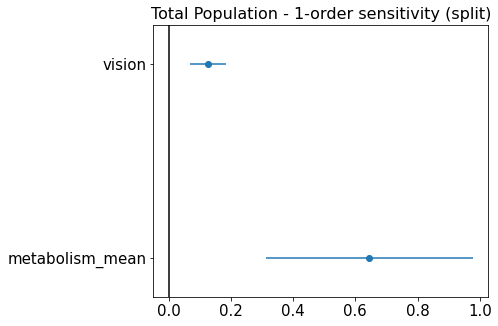

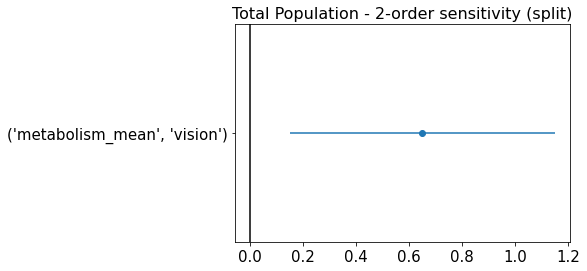

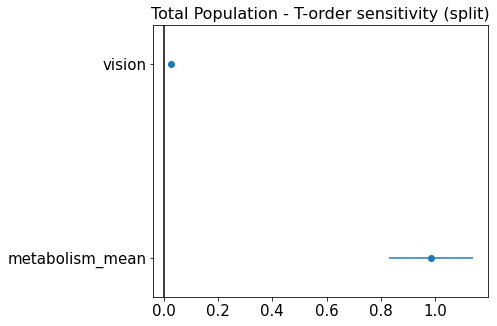

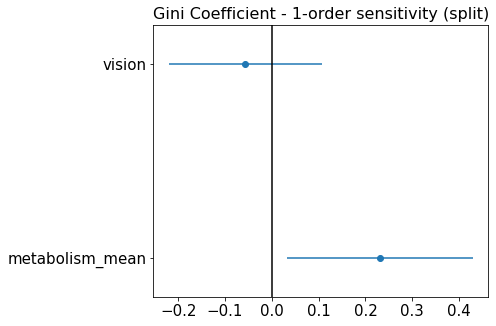

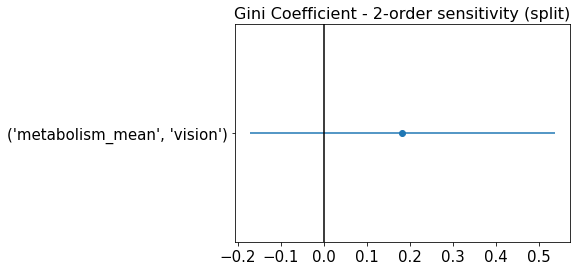

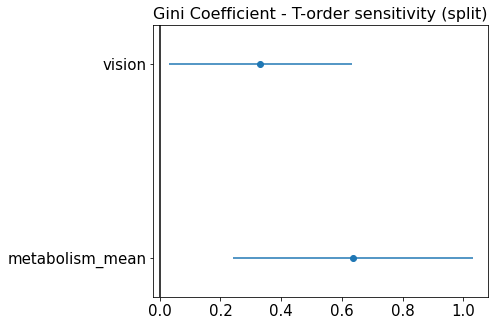

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


                       ST   ST_conf
metabolism_mean  0.834699  0.158744
vision           0.006632  0.003819
                       S1   S1_conf
metabolism_mean  0.747229  0.316484
vision           0.019488  0.059918
                                 S2   S2_conf
(metabolism_mean, vision)  0.003645  0.807469
                       ST   ST_conf
metabolism_mean  1.135193  0.248735
vision           0.175167  0.118732
                       S1   S1_conf
metabolism_mean  1.068935  0.348453
vision          -0.147181  0.106317
                                 S2   S2_conf
(metabolism_mean, vision)  0.210139  1.003118


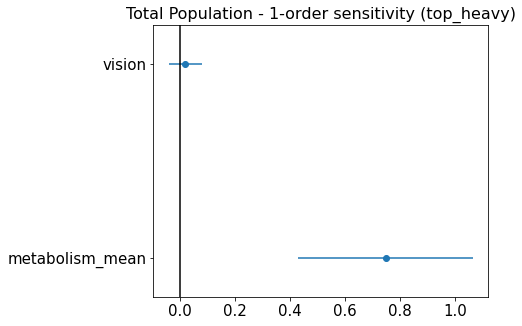

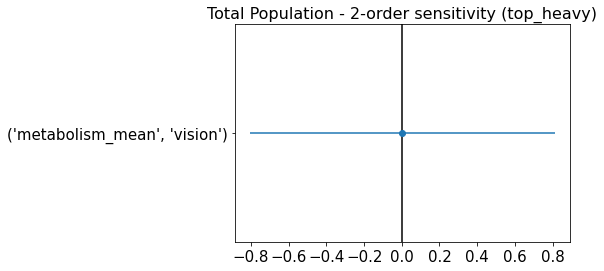

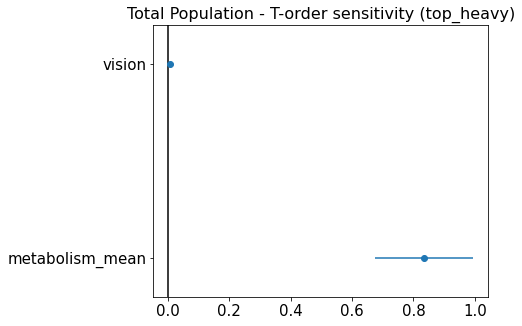

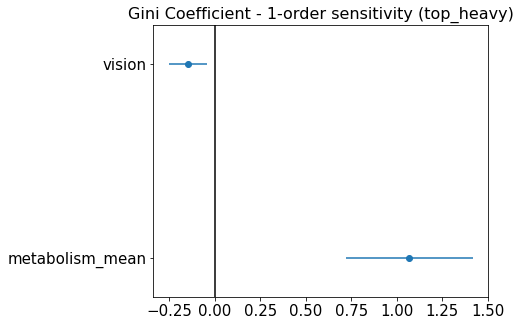

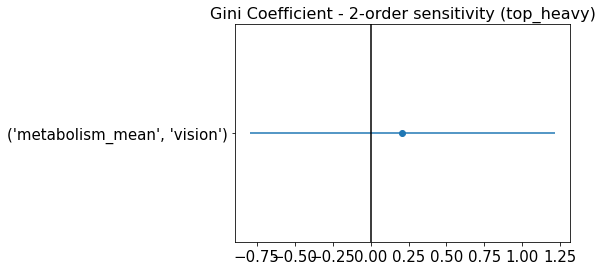

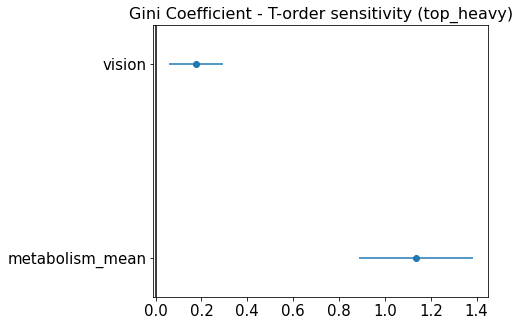

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


                       ST   ST_conf
metabolism_mean  0.803826  0.166780
vision           0.017756  0.020476
                       S1   S1_conf
metabolism_mean  0.822163  0.297934
vision          -0.015276  0.040688
                                 S2   S2_conf
(metabolism_mean, vision)  0.021952  0.769322
                       ST   ST_conf
metabolism_mean  1.229649  0.196248
vision           0.163991  0.162268
                       S1   S1_conf
metabolism_mean  1.077116  0.285267
vision           0.047264  0.201015
                                 S2   S2_conf
(metabolism_mean, vision)  0.084725  0.802491


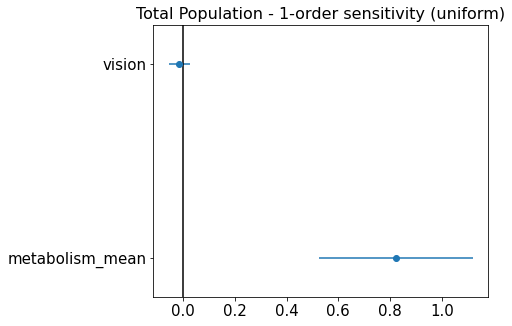

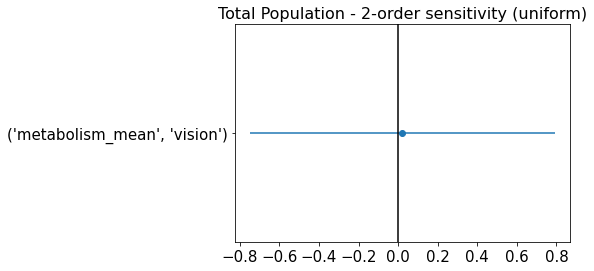

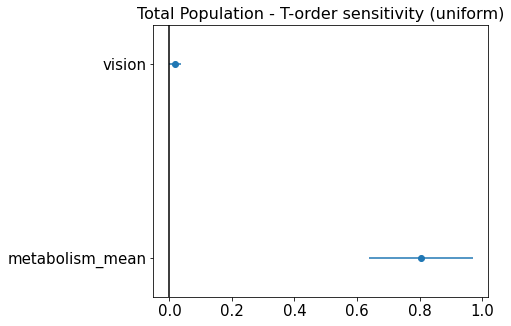

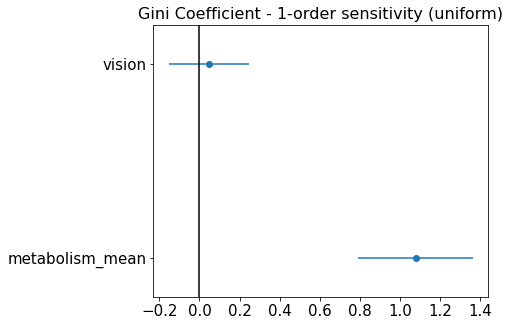

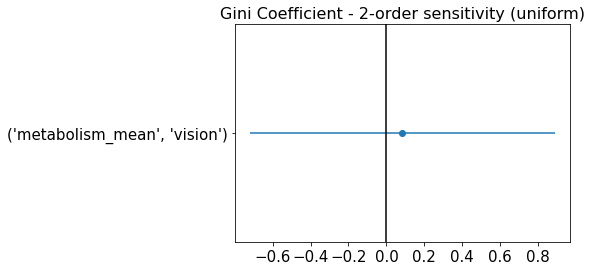

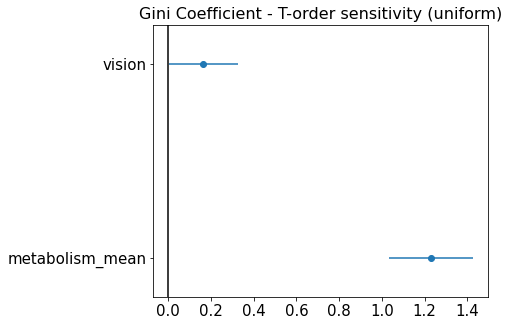

All analysis done and results saved!


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from itertools import combinations
import numpy as np
import os

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[2, 8], [2, 13]]
}

# Function to read and process the data
def read_and_process_data(file_path):
    data = pd.read_csv(file_path)
    data['Total Population'] = data['Total Population'] - 2500
    return data

# Read and process the data for each map scheme
data_split = read_and_process_data('simulation_results_split.csv')
data_top_heavy = read_and_process_data('simulation_results_top_heavy.csv')
data_uniform = read_and_process_data('simulation_results_uniform.csv')

# Define function for sensitivity analysis and plotting
def sensitivity_analysis_and_plot(data, map_scheme):
    # Perform Sobol sensitivity analysis
    Si_population = sobol.analyze(problem, data['Total Population'].values, print_to_console=True)
    Si_gini = sobol.analyze(problem, data['Gini Coefficient'].values, print_to_console=True)

    # Visualization function for sensitivity indices
    def plot_index(s, params, i, title='', output_file=''):
        if i == '2':
            p = len(params)
            params = list(combinations(params, 2))
            indices = s['S' + i].reshape((p ** 2))
            # Filter indices to exclude NaN values
            indices = indices[~np.isnan(indices)]
            errors = s['S' + i + '_conf'].reshape((p ** 2))
            # Filter errors to exclude NaN values
            errors = errors[~np.isnan(errors)]
        else:
            indices = s['S' + i]
            errors = s['S' + i + '_conf']
            plt.figure(figsize=(6, 5))

        l = len(indices)
        plt.title(title, fontsize=16)
        plt.ylim([-0.2, len(indices) - 1 + 0.2])
        plt.yticks(range(l), params)
        # set fontsize for xlabel and ylabel
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
        plt.axvline(0, c='k')
        if output_file:
            plt.savefig(output_file, dpi=500)
        plt.show()

    # Plot and save sensitivity indices
    for Si, output_name in [(Si_population, "Total Population"), (Si_gini, "Gini Coefficient")]:
        for i in ['1', '2', 'T']:
            plot_index(Si, problem['names'], i, f'{output_name} - {i}-order sensitivity ({map_scheme})', f'plots/Undersampling_SA/{output_name}_sensitivity_{i}_{map_scheme}.png')

    # Save the sensitivity analysis results to CSV
    pd.DataFrame(Si_population.to_df()).to_csv(f'sensitivity_analysis_population_{map_scheme}.csv', index=False)
    pd.DataFrame(Si_gini.to_df()).to_csv(f'sensitivity_analysis_gini_{map_scheme}.csv', index=False)

# Ensure the 'plots' directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

# Perform sensitivity analysis and plotting for each map scheme
sensitivity_analysis_and_plot(data_split, 'split')
sensitivity_analysis_and_plot(data_top_heavy, 'top_heavy')
sensitivity_analysis_and_plot(data_uniform, 'uniform')

print("All analysis done and results saved!")

